# Import modules and notebook settings

In [46]:
# Keep modules updated if they change within the session
%load_ext autoreload
%autoreload 2

# Load modules
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import squidpy as sq
import anndata as ad
import scanpy as sc

# Settings
import warnings
warnings.filterwarnings('ignore')
#sc.settings.set_figure_params(dpi=80)

# Print versions
sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.3 scipy==1.9.3 pandas==1.5.1 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.9.11 louvain==0.7.2 pynndescent==0.5.8
squidpy==1.2.3


In [2]:
### To make it more different to Squidpy change and/or increase
# channel order and nr
# and flip spot axis x and y symmetry

# Create AnnData object

### Prepare the data

In [3]:
# Annotations come in a single matrix
data_unformatted = pd.read_csv("input-data/raw-data/Hartmann-2021/scMEP_MIBI_singlecell/scMEP_MIBI_singlecell.csv")
data_unformatted = data_unformatted.dropna(axis=0)

# Some manual matrix formatting
data_unformatted['library_id'] = 'Point' + data_unformatted['point'].astype(str)
data_unformatted['new_index'] = data_unformatted['library_id'].astype(str) + '_' + data_unformatted['cell_id'].astype(str)
data_unformatted = data_unformatted.set_index(pd.Index(data_unformatted['new_index'].to_numpy()))
data_unformatted = data_unformatted.drop('new_index', axis=1)

# Subset and format to adjust to AnnData format
counts = data_unformatted.iloc[:, 3:39]

## Due to AnnData bugs (2022-12-05) we need to either supply a numpy.array or recently created pandas.DataFrame
X = pd.DataFrame(
        counts.to_numpy(),
        columns = list(counts.columns),
        index = list(counts.index)
)
obs = data_unformatted.iloc[:, np.r_[0:3, 39:len(data_unformatted.columns)]]

# adata. obsm: Spatial location of spots
obsm = {
    'spatial': data_unformatted.loc[:, ['center_colcoord', 'center_rowcoord']].to_numpy()
}

# adata.uns: Metadata
sample_info = pd.read_excel(
    "input-data/raw-data/Hartmann-2021/scMEP_MIBI_singlecell/scMEP_sample_description.xlsx",
).to_dict(orient='list')

uns = {
    'sample_info': sample_info,
    'Cluster_colors': [
        '#1f77b4',
        '#ff7f0e',
        '#2ca02c',
        '#d62728',
        '#9467bd',
        '#8c564b',
        '#e377c2',
        '#7f7f7f'
      ]
}


### Create the object

In [4]:
# Create AnnData object
adata = ad.AnnData(
    X = X, 
    obs = obs, 
    obsm = obsm,
    uns = uns
)

### View

In [5]:
adata.to_df()

,H3,vimentin,SMA,CD98,NRF2p,CD4,CD14,CD45,PD1,CD31,...,CD8,CD57,LDHA,IDH2,HK1,Ecad,CPT1A,CK,NaKATPase,HIF1A
Point7_2,0.785881,0.408300,0.696414,0.000000,0.600454,0.000000,0.572489,0.071873,0.000000,0.000000,...,0.000000,0.000000,0.344579,0.502285,0.161829,0.269818,0.324649,0.000000,0.000000,0.000000
Point7_6,0.762130,0.727941,0.692685,0.000000,0.126400,0.000000,0.330630,0.474050,0.000000,0.000000,...,0.468677,0.070334,0.409235,0.481462,0.312938,0.094715,0.354284,0.000000,0.000000,0.000000
Point7_8,0.718484,0.321032,0.270971,0.379427,0.728447,0.239057,0.131221,0.192857,0.000000,0.000000,...,0.033525,0.157202,0.537986,0.543015,0.091759,0.322762,0.443656,0.284286,0.447547,0.000000
Point7_9,0.844099,0.595707,0.643885,0.334527,0.134485,0.531027,0.195556,0.670235,0.053552,0.000000,...,0.114762,0.000000,0.609270,0.499102,0.479794,0.294011,0.444598,0.000000,0.256981,0.106809
Point7_14,0.733856,0.652953,0.461541,0.589736,0.484765,0.356065,0.386779,0.439137,0.000000,0.287635,...,0.019767,0.000000,0.618623,0.557943,0.384368,0.477327,0.559286,0.396537,0.682852,0.204079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Point25_1124,0.606688,0.693328,0.482057,0.000000,0.417442,0.348995,0.499925,0.209032,0.000000,0.000000,...,0.000000,0.000000,0.648503,0.507011,0.117075,0.351623,0.378172,0.000000,0.459636,0.000000
Point25_1125,0.803571,0.704590,0.541540,0.543553,0.276144,0.571832,0.672874,0.727685,0.563716,0.000000,...,0.000000,0.000000,0.663256,0.624918,0.662077,0.394823,0.406933,0.000000,0.494732,0.000000
Point25_1126,0.748780,0.485276,0.868089,0.000000,0.525238,0.263389,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.599062,0.625642,0.426509,0.393277,0.447733,0.000000,0.000000,0.000000
Point25_1127,0.831164,0.812797,0.561337,0.101062,0.578004,0.136832,0.034396,0.000000,0.000000,0.885439,...,0.000000,0.000000,0.650302,0.668709,0.349704,0.379485,0.453863,0.000000,0.336142,0.000000


In [6]:
adata.obs

,row_num,point,cell_id,X1,center_rowcoord,center_colcoord,cell_size,category,donor,Cluster,library_id
Point7_2,0,7,2,63894.0,109.0,6.0,277.0,carcinoma,90de,Imm_other,Point7
Point7_6,3,7,6,63898.0,845.0,5.0,298.0,carcinoma,90de,Imm_other,Point7
Point7_8,4,7,8,63900.0,997.0,17.0,2037.0,carcinoma,90de,Epithelial,Point7
Point7_9,5,7,9,63901.0,192.0,13.0,611.0,carcinoma,90de,Tcell_CD4,Point7
Point7_14,9,7,14,63906.0,913.0,17.0,1616.0,carcinoma,90de,Myeloid_CD68,Point7
...,...,...,...,...,...,...,...,...,...,...,...
Point25_1124,66394,25,1124,50571.0,890.0,1016.0,219.0,carcinoma,21d7,Imm_other,Point25
Point25_1125,66395,25,1125,50572.0,492.0,1018.0,238.0,carcinoma,21d7,Tcell_CD4,Point25
Point25_1126,66396,25,1126,50573.0,618.0,1019.0,283.0,carcinoma,21d7,Fibroblast,Point25
Point25_1127,66397,25,1127,50574.0,65.0,1019.0,138.0,carcinoma,21d7,Endothelial,Point25


In [7]:
adata.obsm

AxisArrays with keys: spatial

In [8]:
adata.uns.keys()

dict_keys(['sample_info', 'Cluster_colors'])

# Integrate image and segmentation mask data

### User input

In [9]:
# The user must choose 3 fluorophore channels to use as RGB raster format
user_input_channels = ['145_CD45', '174_CK', '113_vimentin']
image_dir = "input-data/raw-data/Hartmann-2021/scMEP_MIBI_singlecell/scMEP_MIBI_colon_images/90de_tumor/"
segmentation_dir = "input-data/raw-data/Hartmann-2021/scMEP_MIBI_singlecell/segmentation/"

### Algorithm initiation and filename notation handling

In [10]:
# Paths
image_files = sorted(os.listdir(image_dir))

# Check that image file names are named as in the library_id
if all(np.in1d(image_files, adata.obs['library_id'].to_list())):
    library_ids = image_files
else:
    raise Exception("Image file names must be named equal to library_ids")

# Check if segmentation file names contain the library_id
seg_files = sorted(os.listdir(segmentation_dir))

dict_seg_lib_id = {}

for seg_file in seg_files:
    library_id = seg_file[:-15] ### !!! Can be improved via e.g. regular expressions
    if library_id in set(library_ids): ### CHANGE: set(adata.obs['library_id']):
        dict_seg_lib_id[seg_file] = library_id
    else:
        pass ### Change: raise Exception("library_key not contained in filename string")


# Initialize the spatial dictionary
spatial_dict = {}

### Add images
This algorithm processes both images and segmentation masks separately and tries to attribute the segmentation file names to the image file names by string content.
In the future maybe integrate two alterntive paths:
 - argument indicating a dictionary of file links
 - argument indicating the file name changes/presuffixes that apply to the image file name to arrive at the segmentation file name

In [11]:
for library_id in library_ids:
    
    # Init dict layer 1: 'library_id' = {images, scalefactors}
    spatial_dict[library_id] = {}

    # Init dict layer 2: 'images' = {hires, segmentation}
    spatial_dict[library_id]['images'] = {}
    
    # Fill 'image' key in layer 2
    # 3 channel images as RGB raster 
    # Read .tiff data as array
    # Can also be done with scipy or python image library PIL
    channel_arr = np.array(
        [
            plt.imread(image_dir + library_id + '/' + user_input_channels[0] + ".tif"),
            plt.imread(image_dir + library_id + '/' + user_input_channels[1] + ".tif"),
            plt.imread(image_dir + library_id + '/' + user_input_channels[2] + ".tif")
        ]
    ).transpose(1, 2, 0)
    
    spatial_dict[library_id]['images']['hires'] = channel_arr
    
    # Fill 'scalefactors' key in layer 1
    spatial_dict[library_id]['scalefactors'] = {
        'spot_diameter_fullres': 15,
        'tissue_hires_scalef': 1,
    }

### Add segmentation data

In [12]:
for key, value in dict_seg_lib_id.items():

    # Fill 'segmentation' key in layer 2
    spatial_dict[value]['images']['segmentation'] = plt.imread(segmentation_dir + key)
    
    # Add 'tissue_segmentation_scalef' key in layer 1
    spatial_dict[value]['scalefactors']['tissue_segmentation_scalef'] = 1

### Final integration

In [13]:
# Integrate spatial dictionary into adata
adata.uns['spatial'] = spatial_dict

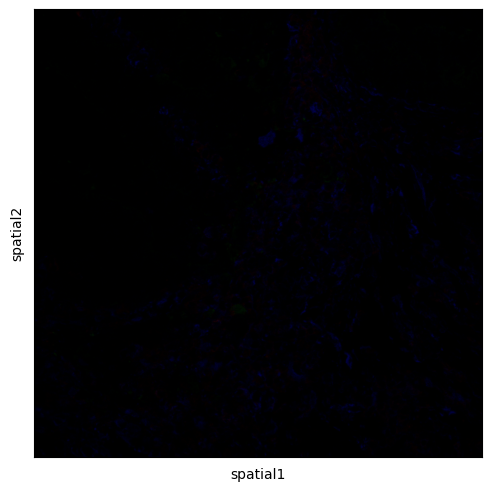

In [14]:
sq.pl.spatial_scatter(adata, color=[None], library_key='library_id', library_id='Point8')

In [15]:
# testim1 = plt.imread("bioinformatics/Hartmann-2020/scMEP_MIBI_colon_images/90de_tumor/Point1/113_vimentin.tif")
# testim2 = plt.imread("bioinformatics/Hartmann-2020/scMEP_MIBI_colon_images/90de_tumor/Point1/145_CD45.tif")
# testim3 = plt.imread("bioinformatics/Hartmann-2020/scMEP_MIBI_colon_images/90de_tumor/Point1/174_CK.tif")
# testim = np.array([testim1, testim2, testim3], dtype='uint8').reshape(1024, 1024, 3)
# testim

In [16]:
# print(testim[500, 1, : ])
# print(testim1[500, 1])
# print(testim2[500, 1])
# print(testim3[500, 1])

# Visualize

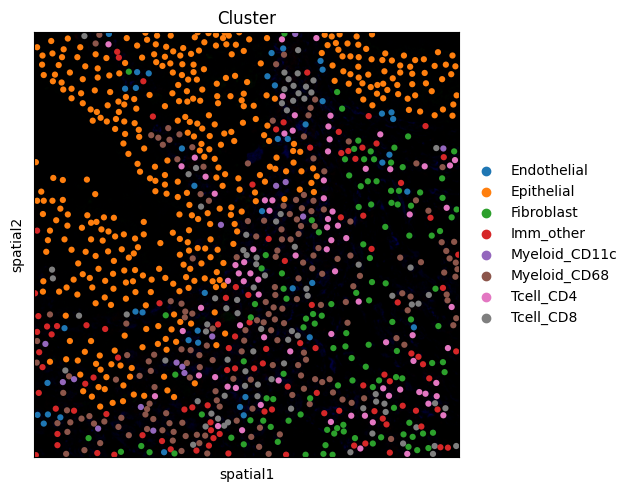

In [17]:
sq.pl.spatial_scatter(adata, color=['Cluster'], library_key='library_id', library_id=['Point8'])

In [18]:
### Segmentation mask

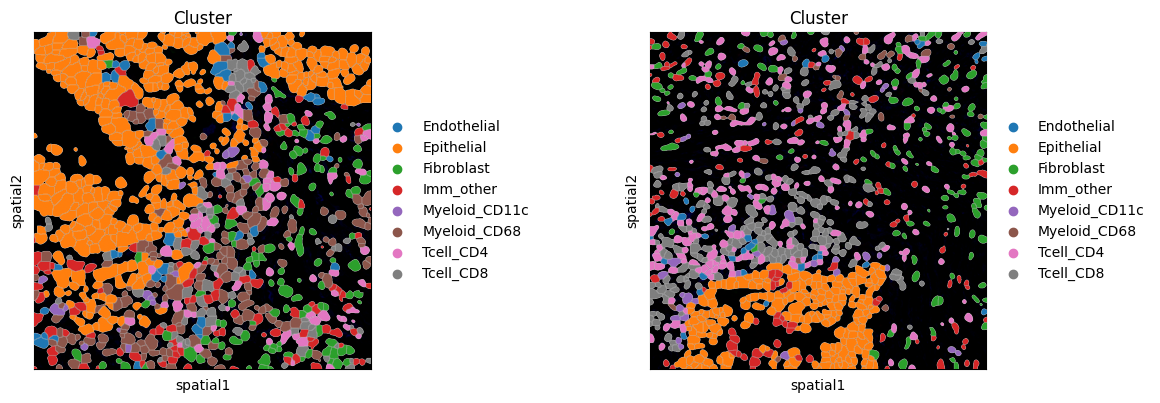

In [19]:
sq.pl.spatial_segment(adata, library_key='library_id', library_id=['Point8', 'Point16'], seg_cell_id='cell_id', color='Cluster')

### Expression under mask

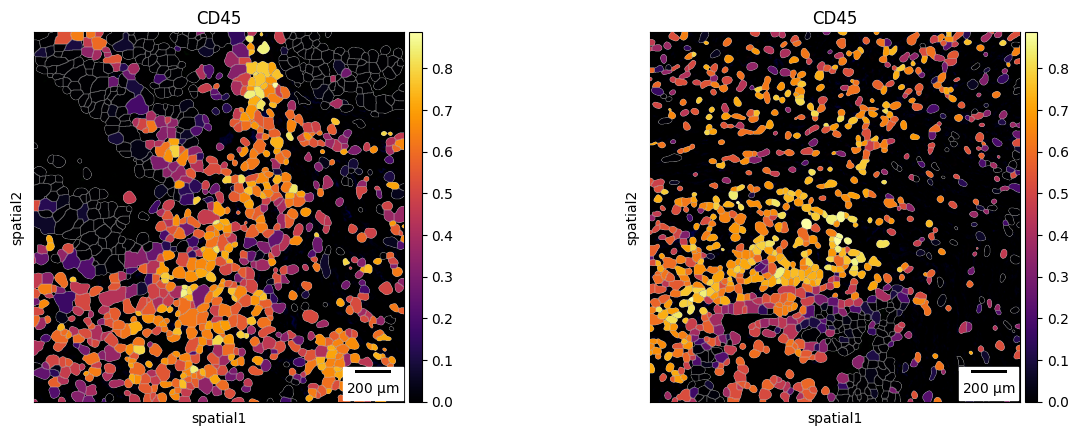

In [20]:
sq.pl.spatial_segment(
    adata,
    color='CD45', # Immune cell marker (differentiated)
    library_key='library_id',
    library_id=['Point8', 'Point16'],
    seg_cell_id='cell_id',
    cmap='inferno',
    scalebar_dx=2.0,
    scalebar_kwargs={'scale_loc': 'bottom', 'location': 'lower right'}
)

# Expression of some specific markers

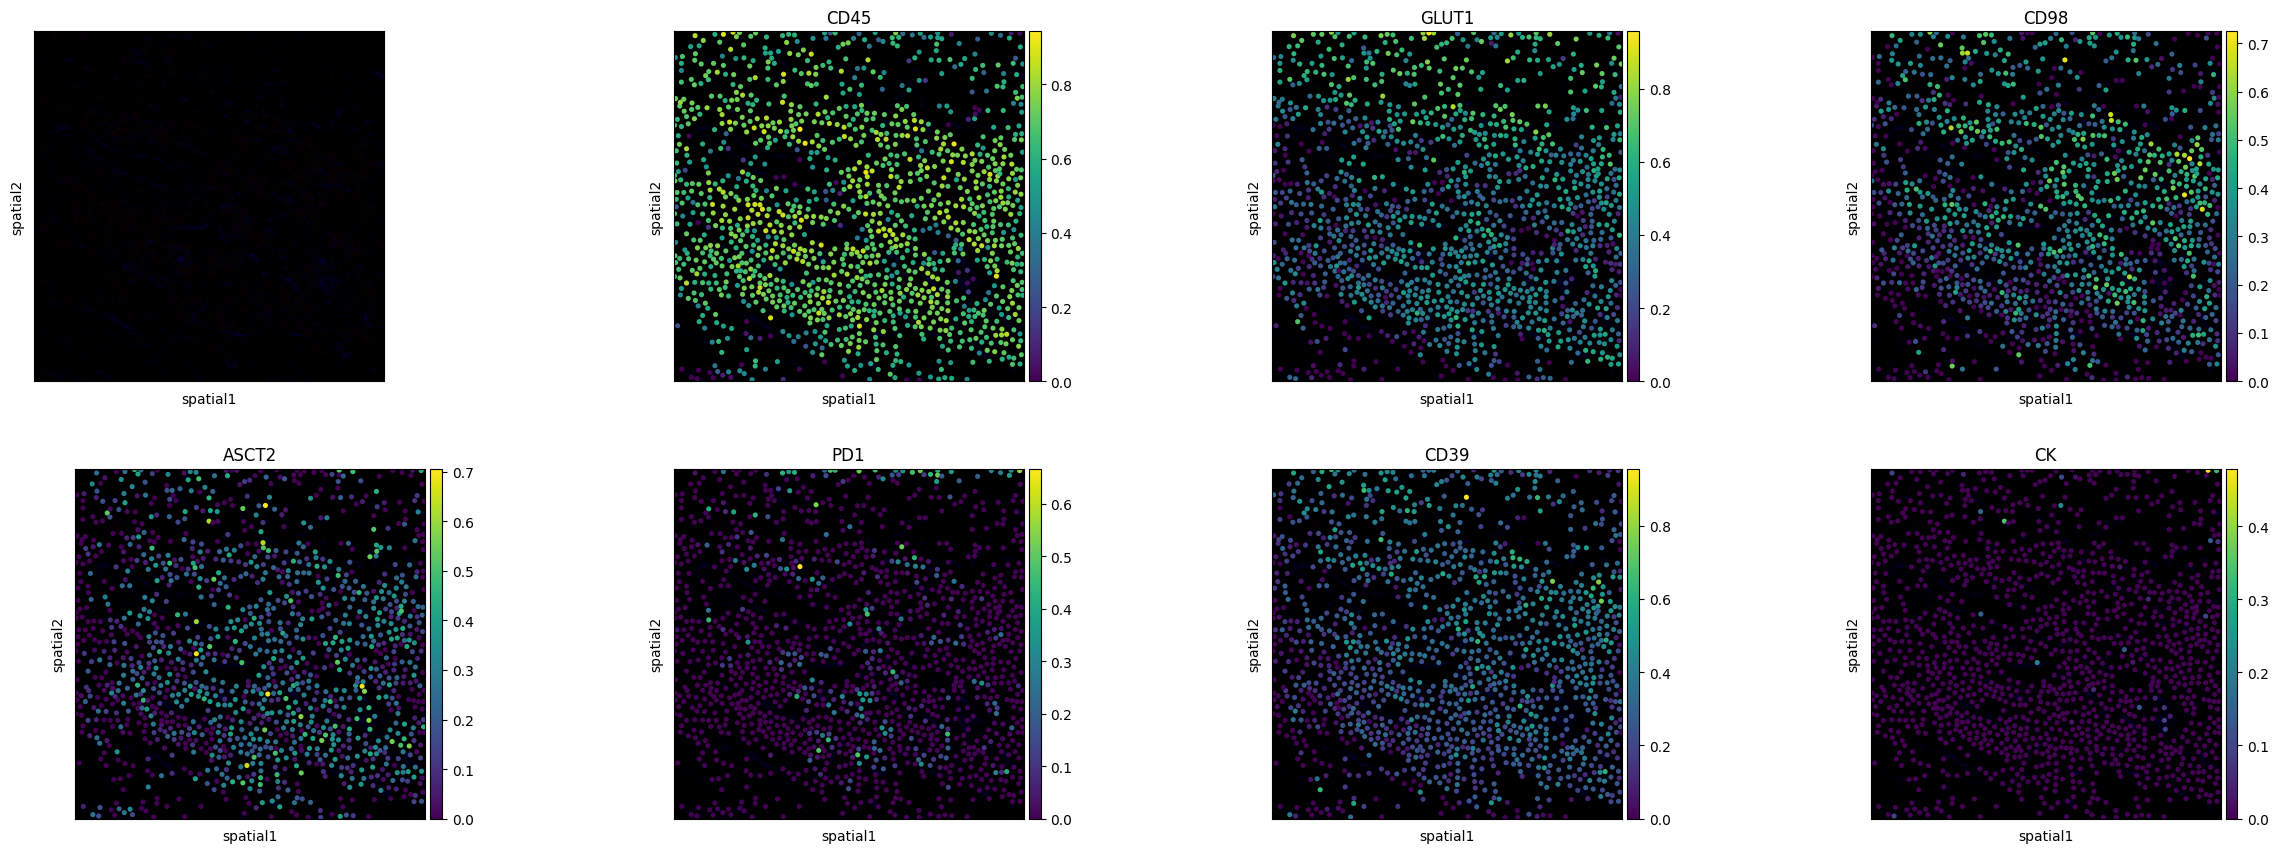

In [21]:
sq.pl.spatial_scatter(
    adata,
    color=[None,
           'CD45', # Hematopoietic cells (differentiated)
           'GLUT1', # Glucose transporter
           'CD98', # Amino acid transporter, auth: found polarized towards tumour-immune border
           'ASCT2', # -||-
           'PD1', # Immune activation marker
           'CD39', # -||-
           'CK', # Cancer marker
           ],
    library_key='library_id',
    library_id='Point1')

# Create spatial connectivity graph

In [22]:
sq.gr.spatial_neighbors(adata, n_neighs=10, coord_type='generic')

# Save adata object

In [28]:
adata.write('output-data/Hartmann-2021/hartmann.h5ad', compression='gzip')

# NCEM

Output:
 - Coupling analysis: DEGs
 - Coupling analysis circular: DEGs or magnitude
 - Sender effect on receiving cell
 - Sender-receiver vulcano plot
 - **Sender similarity analysis**

Not functioning:
 - Grid searches over neighbourhood sizes + Length scales of dependencies for different target cell-types
 - (Squidpy CellPhoneDB)

Outlook:
- Future custom loader


In [47]:
import ncem

### 0. Loading the data with the predefined data loader

In [55]:
interpreter = ncem.interpretation.interpreter.InterpreterInteraction()
interpreter.get_data(
    data_origin='hartmann', # Reference to specfic DataLoader (see notes in Dropbox paper)
    data_path='input-data/raw-data/Hartmann-2021/',
    radius=35,
    node_label_space_id='type',
    node_feature_space_id='standard',
)
print('\n Celldata metadata:', interpreter.data.celldata.uns['metadata'])

Loading data from raw files
registering celldata
collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 49.99it/s]

Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036

 Celldata metadata: {'lateral_resolution': 0.390625, 'fn': ['scMEP_MIBI_singlecell/scMEP_MIBI_singlecell.csv', 'scMEP_sample_description.xlsx'], 'image_col': 'point', 'pos_cols': ['center_colcoord', 'center_rowcoord'], 'cluster_col': 'Cluster', 'cluster_col_preprocessed': 'Cluster_preprocessed', 'patient_col': 'donor'}


0.0
1.000547499859607
10.193272571484671
128.1181909355233
1071.8057746883462


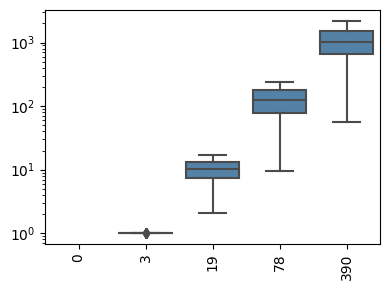

In [53]:
# node degrees for different radii
interpreter.data.plot_degree_vs_dist(
    max_distances=[0, 10, 50, 200, 1000],
    lateral_resolution=400/1024, # Physical cell resolution
)

### 2. Extracting sender-receiver effects with NCEM

In [62]:
# splitting data into test and validation sets, can be ignored for non sender-receiver focused analysis
interpreter.split_data_node(0.1, 0.1)
interpreter.n_eval_nodes_per_graph = 10
interpreter.cell_names = list(interpreter.data.celldata.uns['node_type_names'].values())

Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51914 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 



In [63]:
interpreter.get_sender_receiver_effects()

2022-12-07 00:32:35.047664: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 00:32:35.048207: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-07 00:32:35.049010: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-12-07 00:32:35.049192: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-12-07 00:32:35.049263: W tensorflow/c

using ols parameters.
calculating inv fim.


### Type coupling analysis

Heatmap color is proportional to the number of differentially expressed genes at a FDR-corrected p-value threshold of 0.05 for each pair of sender and receiver cell types. 

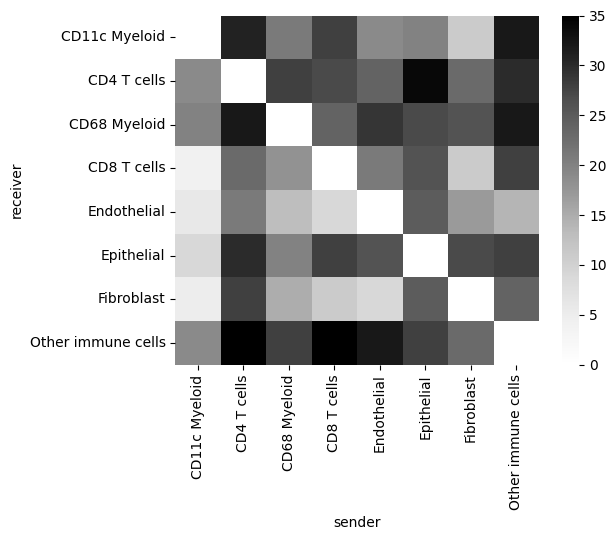

In [64]:
interpreter.type_coupling_analysis(figsize=(6.5, 5.5))

Edge width proportional to the number of differentially expressed genes at a FDR-corrected p-value threshold of 0.05 for each pair of sender and receiver cell types. Only edges with eat least 24 differentially expressed genes are shown.


**Arrow thickness:** strength of directional dependencies between cell types as the magnitude of the corresponding coefficient vector

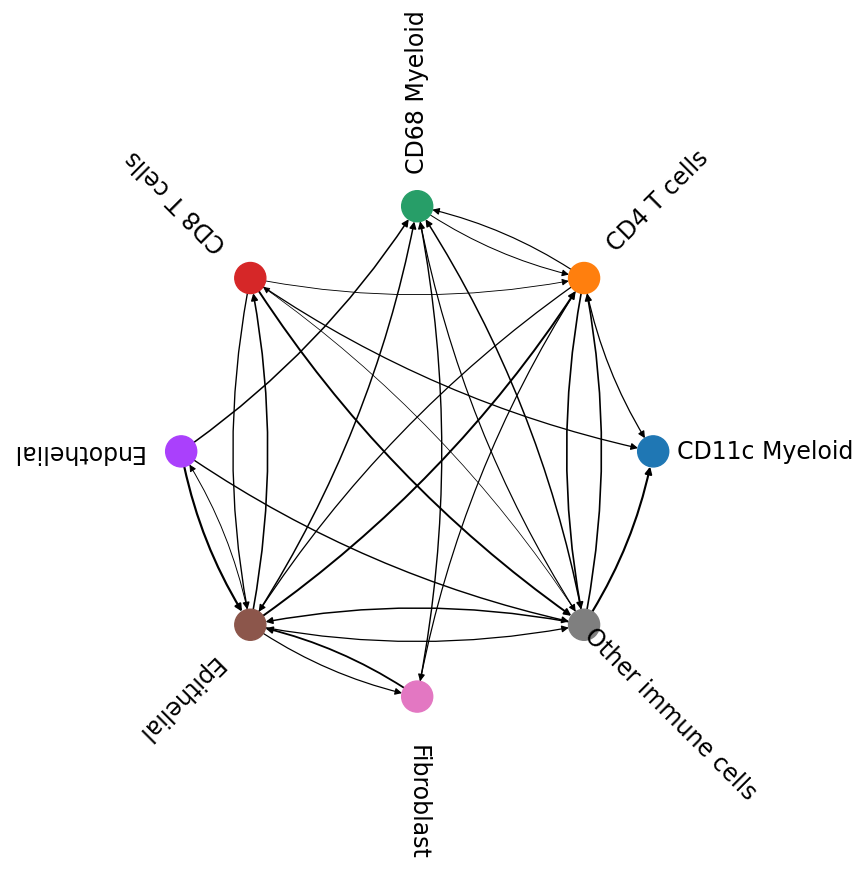

,sender,receiver,0,magnitude,de_genes,de_genes_abs
1,CD11c Myeloid,CD4 T cells,19,0.183663,0.483871,19
2,CD11c Myeloid,CD68 Myeloid,20,0.182613,0.516129,20
3,CD11c Myeloid,CD8 T cells,4,0.059416,0.000000,4
4,CD11c Myeloid,Endothelial,6,0.143681,0.064516,6
5,CD11c Myeloid,Epithelial,9,0.191141,0.161290,9
6,CD11c Myeloid,Fibroblast,5,0.159925,0.032258,5
7,CD11c Myeloid,Other immune cells,19,0.240403,0.483871,19
8,CD4 T cells,CD11c Myeloid,31,0.259385,0.870968,31
10,CD4 T cells,CD68 Myeloid,32,0.242240,0.903226,32
11,CD4 T cells,CD8 T cells,23,0.070209,0.612903,23


In [65]:
interpreter.type_coupling_analysis_circular(
    edge_attr='magnitude', # IDF: Alternatives should be: ["magnitude", 'de_genes', 'de_genes_abs']
    edge_width_scale=3.5,
    de_genes_threshold=24,
    figsize=(9,9),
    text_space=1.35
)

### IDF: edge thickness = #(DEGs) to relate to the coupling analysis heatmap

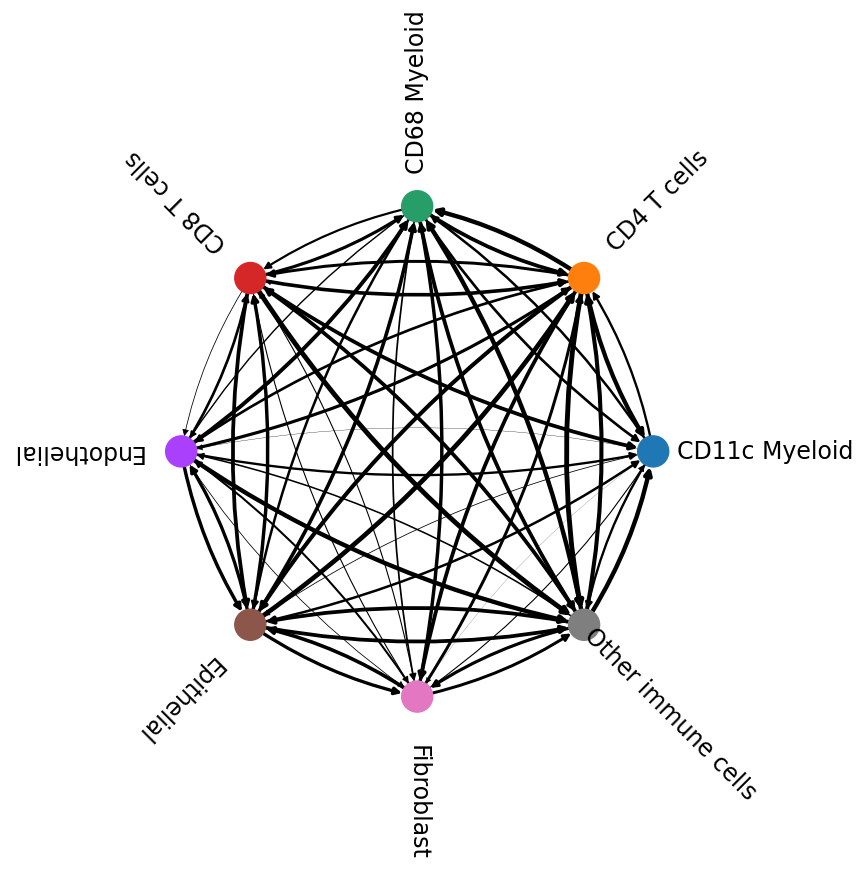

,sender,receiver,0,magnitude,de_genes,de_genes_abs
1,CD11c Myeloid,CD4 T cells,19,0.183663,0.483871,19
2,CD11c Myeloid,CD68 Myeloid,20,0.182613,0.516129,20
3,CD11c Myeloid,CD8 T cells,4,0.059416,0.000000,4
4,CD11c Myeloid,Endothelial,6,0.143681,0.064516,6
5,CD11c Myeloid,Epithelial,9,0.191141,0.161290,9
6,CD11c Myeloid,Fibroblast,5,0.159925,0.032258,5
7,CD11c Myeloid,Other immune cells,19,0.240403,0.483871,19
8,CD4 T cells,CD11c Myeloid,31,0.259385,0.870968,31
10,CD4 T cells,CD68 Myeloid,32,0.242240,0.903226,32
11,CD4 T cells,CD8 T cells,23,0.070209,0.612903,23


In [66]:
interpreter.type_coupling_analysis_circular(
    edge_attr='de_genes',
    edge_width_scale=3.5,
    de_genes_threshold=1,
    figsize=(9,9),
    text_space=1.35
)

### 3. Directional sender effects for Epithelial cells and CD8 T cells

We dissected these couplings based on the gene-wise effects of all senders on one receiver type for CD8T cells and Epithelial cells which contextualizes differential expression results of the CD8T cell–Epithelial cell axis.

NCEM correctly identifies genes and proteins that play roles in T-cell activation, regulation of T-cell antigen receptor signalling and immune response.

### a) Sender effects on CD8 T cells 

“Sender effect” analysis heatmap for CD8 T cells. Shown is the estimated log fold change that the sender cell type on the x-axis induces in the gene on the y axis in receiving CD8 T cells.

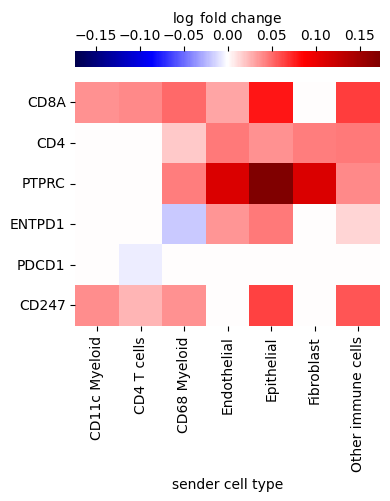

In [67]:
interpreter.sender_effect(
    receiver='CD8 T cells', 
    gene_subset=['CD8A', 'CD4', 'PTPRC', 'ENTPD1', 'PDCD1', 'CD247'], 
    figsize=(4,5)
)

### b) Sender effects on Epithelial cells

“Sender effect” analysis heatmap for Epithelial cells. Shown is the estimated log fold change that the sender cell type on the y-axis induces in the gene on the x axis in receiving Epithelial cells.

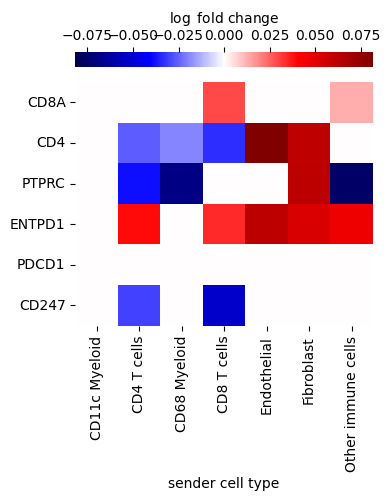

In [68]:
interpreter.sender_effect(
    receiver='Epithelial', 
    gene_subset=['CD8A', 'CD4', 'PTPRC', 'ENTPD1', 'PDCD1', 'CD247'], 
    figsize=(4,5)
)

### c) Directional effect for sender-receiver axis for CD8 T cells on Epithelial cells 

This analysis contextualizes differential expression results of the CD8 Tcell – Epithelial cell axis.

Volcano plot of differentially expressed genes of Epithelial cells in the neighborhood of CD8 T cells.

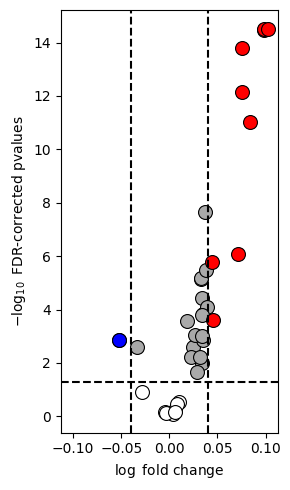

In [69]:
interpreter.sender_receiver_effect_vulcanoplot(
    sender='CD8 T cells', 
    receiver='Epithelial',
    fold_change_threshold=0.04,
    figsize=(3,5)
)

In [70]:
# low fold change
interpreter.sender_receiver_values(
    sender='CD8 T cells', 
    receiver='Epithelial'
).sort_values(by='fold change').head(5)

,mean expression,pvalue,qvalue,fold change,-log 10 qvalue
CD247,0.033484,0.000763,0.001416,-0.052485,2.848959
CD4,0.443922,0.001464,0.002639,-0.033691,2.578560
PTPRC,0.092476,0.084400,0.118958,-0.028595,0.924605
PECAM1,0.019289,0.629176,0.687531,-0.004426,0.162707
LDHA,0.631155,0.669940,0.723233,-0.003232,0.140721


In [71]:
# high fold change
interpreter.sender_receiver_values(
    sender='CD8 T cells', 
    receiver='Epithelial'
).sort_values(by='fold change', ascending=False).head(5)

,mean expression,pvalue,qvalue,fold change,-log 10 qvalue
ATP1A1,0.601786,0.000000e+00,0.000000e+00,0.102429,inf
SLC1A5,0.617981,0.000000e+00,0.000000e+00,0.098477,inf
SLC3A2,0.458504,8.881784e-16,3.385527e-15,0.098253,14.470374
CKM,0.491795,2.913225e-12,9.619210e-12,0.084243,11.016861
CDH1,0.538660,2.060574e-13,7.207838e-13,0.075619,12.142195


### 4. Sender similarity analysis for Epithelial cells

“Sender similarity analysis” of all sender cell types with respect to Epithelial cell receivers. Shown is a clustered heatmap of Pearson correlation coefficients of the coefficient vectors of each sender type that corresponds to Epithelial cell receivers.

T cell clusters and other immune cells had a similar effect on Epithelial cells in a “sender similarity analysis”, in which we correlated the coefficient vectors of sender cell types that correspond to Epithelial cell receivers, which demonstrates conservation of cell type identity in the sender profile.

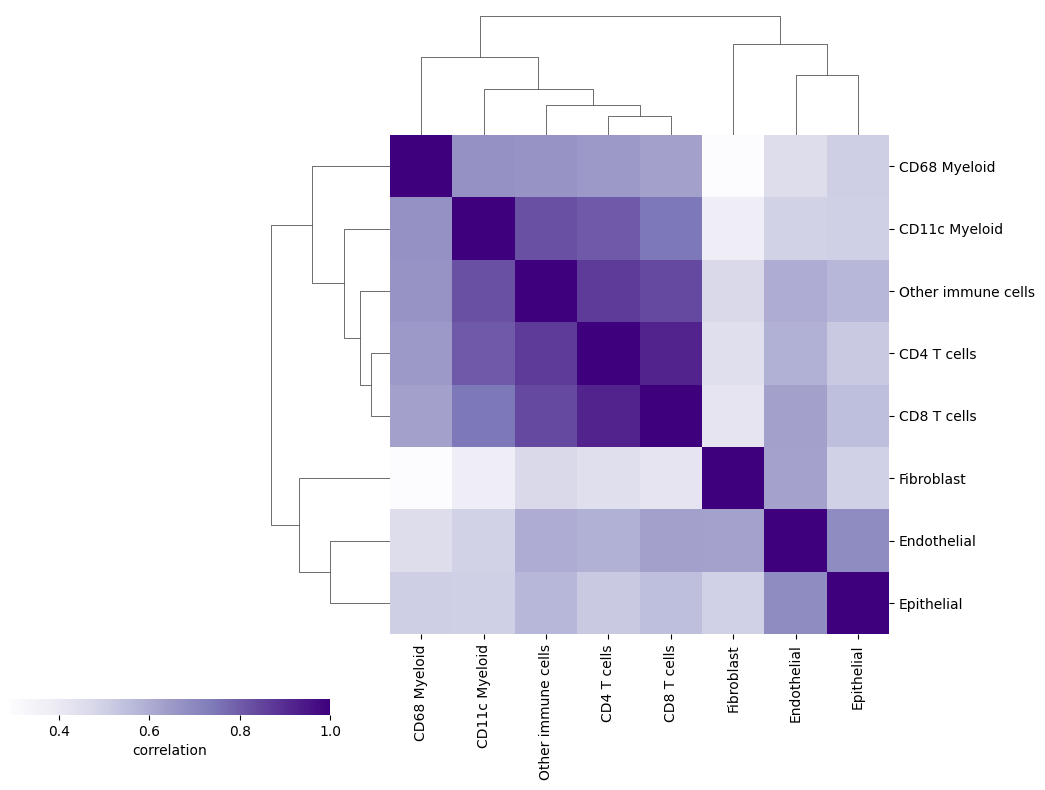

In [72]:
interpreter.sender_similarity_analysis(receiver='Epithelial')